# Example Interrupted Time Series (ITS) with `pymc` models when the treatment time is unknown

This notebook demonstrates a new feature of the InterruptedTimeSeries class in CausalPy: it now supports models that can infer the treatment time directly from the data.

We illustrate this using a built-in model from the CausalPy library, which only requires specifying the effect of the intervention. From this, the model estimates when the intervention likely occurred.

The setting involves a single treated time series, without control units, and with only basic predictors such as time and calendar month.



In [3]:
import arviz as az
import matplotlib.pyplot as plt

import causalpy as cp

In [9]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\matplotlib_inline\config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


## Interrupted Time Series (ITS) Example

Load data

In [5]:
df = cp.load_data("its")

df.head()

,date,month,year,t,y
0,2010-01-31,1,2010,0,25.058186
1,2010-02-28,2,2010,1,27.189812
2,2010-03-31,3,2010,2,26.487551
3,2010-04-30,4,2010,3,31.241716
4,2010-05-31,5,2010,4,40.753973


Visualize the data

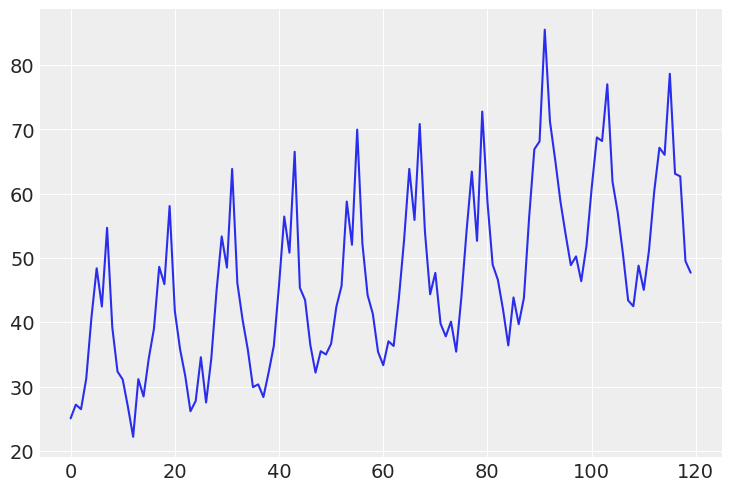

In [6]:
y = df["y"]
t = df["t"]
plt.plot(t, y)

Looking at the data, we observe a noticeable increase in the number of deaths between timestamps 80 and 100. After this period, the values seem to return to their previous level.

In this example, we will build a model using the "impulse" effect to represent this transient deviation. We won’t specify the exact location of the intervention; instead, the model will infer it from the data.

There are three types of effects supported bby this model:

- `"level"` and `"trend"`: each defined by two parameters `[mu, sigma]`, corresponding to a Normal prior `pm.Normal(mu, sigma)`.

- `"impulse"`: defined by three parameters `[mu, sigma1, sigma2]`, where the amplitude follows `pm.Normal(mu, sigma1)` and the decay follows `pm.HalfNormal(sigma2)`.

:::{note} When specifying an effect's parameters, you must provide all of them. If any are missing, the model will fall back to default values. :::

In [10]:
from causalpy.pymc_models import InterventionTimeEstimator as ITE

model = ITE(priors={"impulse": []}, sample_kwargs={"random_seed": seed})

Run the analysis

Optionally, instead of providing a fixed `treatment_time`, we can guide the inference by specifying a time_range as a tuple — for example, restricting the intervention to occur between timestamps 80 and 100. Leaving `treatment_time=None` allows the model to search freely over all possible timestamps, but adding a constraint typically speeds up inference and focuses the posterior on plausible regions.

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [12]:
from causalpy.experiments.interrupted_time_series import InterruptedTimeSeries as ITS

result = ITS(df, treatment_time=(80, 100), formula="y ~ 1 + t + C(month)", model=model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [switchpoint, beta, impulse_amplitude, decay_rate, sigma, y_hat]


Output()

ValueError: Not enough samples to build a trace.

Plot the results

:::{note}

The model estimates the latent time series mu_hat by combining two components:

- `mu`: the part inferred from the user-defined formula (e.g. time + month),

- `mu_in`: the contribution from the intervention effect.

In the plots, we display only `mu` — the baseline prediction based on the formula — to better highlight the causal impact of the intervention. This makes it easier to see how the observed data diverge from what would be expected without the effect.

In contrast, evaluation metrics like R² and standard deviation are computed using `mu_hat`, which includes both the formula and the intervention effect.
As a result, R² may appear higher than what the plots suggest.
:::

In [13]:
fig, ax = result.plot()

NameError: name 'result' is not defined

In [8]:
result.summary()

==================================Pre-Post Fit==================================
Formula: y ~ 1 + t + C(month)
Model coefficients:
    Intercept       22, 94% HDI [21, 24]
    C(month)[T.2]   3.6, 94% HDI [1.8, 5.3]
    C(month)[T.3]   1.3, 94% HDI [-0.36, 3]
    C(month)[T.4]   7.1, 94% HDI [5.3, 8.8]
    C(month)[T.5]   16, 94% HDI [14, 17]
    C(month)[T.6]   25, 94% HDI [23, 27]
    C(month)[T.7]   20, 94% HDI [18, 22]
    C(month)[T.8]   34, 94% HDI [32, 36]
    C(month)[T.9]   17, 94% HDI [15, 19]
    C(month)[T.10]  11, 94% HDI [9.3, 13]
    C(month)[T.11]  6.5, 94% HDI [4.8, 8.2]
    C(month)[T.12]  1.3, 94% HDI [-0.44, 3]
    t               0.2, 94% HDI [0.19, 0.21]
    sigma           2, 94% HDI [1.8, 2.3]


As well as the model coefficients, we might be interested in the average causal impact and average cumulative causal impact.

:::{note}
Better output for the summary statistics are in progress!
:::

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [9]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,3.217,0.535,2.224,4.218,0.011,0.006,2185.0,3163.0,1.0


:::{warning}
Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [10]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,96.52,16.049,66.717,126.543,0.344,0.187,2185.0,3163.0,1.0
